In [130]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms
import numpy as np
from rdkit.Chem import Draw
sdf = Chem.SDMolSupplier( "3d_amine.sdf", removeHs=False )
mols = [ m for m in sdf ]
mol = mols[1]
mol.GetSubstructMatch( Chem.MolFromSmarts( "N[H]" ) )
atoms = [atom for atom in mol.GetAtoms()]

def getev( mol ):
    if mol.GetNumConformers() >= 1:
        matches = mol.GetSubstructMatches( Chem.MolFromSmarts( "N[H]" ) )
        conf = mol.GetConformer()
        theata = rdMolTransforms.GetDihedralDeg( conf,
                                                matches[0][1],
                                                matches[0][0],
                                                matches[1][0],
                                                matches[1][1]  )
        temp_phi1 = 180 - rdMolTransforms.GetAngleDeg(conf,
                                           matches[1][0],
                                           matches[0][0],
                                           matches[0][1]
                                          )
        temp_phi2 = 180 - rdMolTransforms.GetAngleDeg(conf,
                                           matches[0][0],
                                           matches[1][0],
                                           matches[1][1]
                                          )
        if temp_phi1 >= temp_phi2:
            phi1 = temp_phi1
            phi2 = temp_phi2
        else:
            phi1 = temp_phi2
            phi2 = temp_phi1
            
        r = rdMolTransforms.GetBondLength( conf, matches[0][0], matches[1][0] )
        return theata, phi1, phi2, r
    else:
        print( "No conformer!" )


def transform_cartegian( theata, phi1, phi2, r ):
    theata = np.deg2rad( theata )
    phi1 = np.deg2rad( phi1 )
    phi2 = np.deg2rad( phi2 )
    x = np.sin( theata ) * np.sin( phi1 ) * np.sin( phi2 ) *r
    y = np.sin( theata ) * np.sin( phi1 ) * np.cos( phi2 ) *r
    z = np.sin( theata ) * np.cos( phi1 ) *r
    t = np.cos( theata ) *r
    return x, y, z, t

def get_dist(v1,v2):
    v1 = np.asarray( v1 )
    v2 = np.asarray( v2 )
    delta =  v1 - v2
    d = np.linalg.norm( delta )
    return d


In [131]:
def calc_distance( mol1, mol2 ):
    theata1, phi11, phi21, r1 = getev( mol1 )
    theata2, phi12, phi22, r2 = getev( mol2 )
    cart1 = transform_cartegian( theata1, phi11, phi21, r1 )
    cart2 = transform_cartegian( theata2, phi12, phi22, r2 )
    d = get_dist( cart1, cart2 )
    return d

In [139]:
for i, mol in enumerate( mols ):
    d = calc_distance(mols[3],mol)
    print( 0, i, d )

0 0 4.90798883048
0 1 1.48017700543
0 2 6.08814365316
0 3 0.0
0 4 3.93873942603
0 5 5.45068906229
0 6 1.40146560569
0 7 0.0619944778129
0 8 6.92182054937
0 9 6.22560061852
0 10 6.19913412456
0 11 5.75093874617
0 12 5.38531808804
0 13 1.85179121146
0 14 1.80235655185


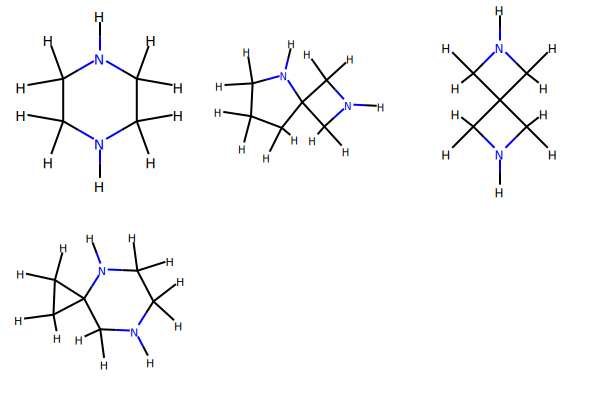

In [140]:
Draw.MolsToGridImage( [mols[3],mols[1], mols[6], mols[7]] )